# 01 - Exploratory Data Analysis ( EDA - WineQT) 

Este notebook carrega o dataset WineQT do Hugging Face, faz uma inspeção inicial e mostra estatísticas descritivas, distribuições e correlações.




# Imports

In [7]:
import warnings; warnings.filterwarnings('ignore')
import os, sys
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.dummy import DummyClassifier
from sklearn.metrics import balanced_accuracy_score, f1_score, make_scorer
from sklearn.utils.class_weight import compute_class_weight

In [8]:
sys.path.append(str(Path.cwd().parent))

from src.data_ingestion import load_wine_dataframe

# Config
HF_REPO = os.getenv("HF_DATASET_REPO", "henriquebap/wine-ml-dataset")
FILENAME = os.getenv("HF_DATASET_FILENAME", "WineQT.csv")

# Load
df = load_wine_dataframe(repo_id=HF_REPO, filename=FILENAME)
df.head()


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [9]:
df.tail(10)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
1133,6.7,0.320,0.44,2.4,0.061,24.0,34.0,0.99484,3.29,0.80,11.6,7
1134,7.5,0.310,0.41,2.4,0.065,34.0,60.0,0.99492,3.34,0.85,11.4,6
1135,5.8,0.610,0.11,1.8,0.066,18.0,28.0,0.99483,3.55,0.66,10.9,6
1136,6.3,0.550,0.15,1.8,0.077,26.0,35.0,0.99314,3.32,0.82,11.6,6
1137,5.4,0.740,0.09,1.7,0.089,16.0,26.0,0.99402,3.67,0.56,11.6,6
1138,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1139,6.8,0.620,0.08,1.9,0.068,28.0,38.0,0.99651,3.42,0.82,9.5,6
1140,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1141,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1142,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


- Informacoes e Descricao do nosso Dataset

In [10]:
print(df.shape)
df.info()
df.describe().T


(1143, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1143 entries, 0 to 1142
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1143 non-null   float64
 1   volatile acidity      1143 non-null   float64
 2   citric acid           1143 non-null   float64
 3   residual sugar        1143 non-null   float64
 4   chlorides             1143 non-null   float64
 5   free sulfur dioxide   1143 non-null   float64
 6   total sulfur dioxide  1143 non-null   float64
 7   density               1143 non-null   float64
 8   pH                    1143 non-null   float64
 9   sulphates             1143 non-null   float64
 10  alcohol               1143 non-null   float64
 11  quality               1143 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 107.3 KB


,count,mean,std,min,25%,50%,75%,max
fixed acidity,1143.0,8.311111,1.747595,4.60000,7.10000,7.90000,9.100000,15.90000
volatile acidity,1143.0,0.531339,0.179633,0.12000,0.39250,0.52000,0.640000,1.58000
citric acid,1143.0,0.268364,0.196686,0.00000,0.09000,0.25000,0.420000,1.00000
residual sugar,1143.0,2.532152,1.355917,0.90000,1.90000,2.20000,2.600000,15.50000
chlorides,1143.0,0.086933,0.047267,0.01200,0.07000,0.07900,0.090000,0.61100
free sulfur dioxide,1143.0,15.615486,10.250486,1.00000,7.00000,13.00000,21.000000,68.00000
total sulfur dioxide,1143.0,45.914698,32.782130,6.00000,21.00000,37.00000,61.000000,289.00000
density,1143.0,0.996730,0.001925,0.99007,0.99557,0.99668,0.997845,1.00369
pH,1143.0,3.311015,0.156664,2.74000,3.20500,3.31000,3.400000,4.01000
sulphates,1143.0,0.657708,0.170399,0.33000,0.55000,0.62000,0.730000,2.00000


| Feature               | Significado                                                                                                   |
|-----------------------|----------------------------------------------------------------------------------------------------------------------|
| fixed acidity         | Ácidos fixos (não voláteis) presentes no vinho; não evaporam facilmente e influenciam a acidez total e o sabor.     |
| volatile acidity      | Quantidade de ácido acético; em níveis altos pode gerar aroma/sabor avinagrado desagradável.                        |
| citric acid           | Ácido cítrico em pequenas quantidades; adiciona sensação de “frescor” e pode realçar o sabor do vinho.              |
| residual sugar        | Açúcar remanescente após a fermentação; é raro < 1 g/L; > 45 g/L geralmente classifica o vinho como doce.           |
| chlorides             | Teor de cloretos (sal) no vinho.                                                                                    |
| free sulfur dioxide   | SO₂ livre em equilíbrio entre forma molecular (gás dissolvido) e bissulfito; inibe microrganismos e oxidação.       |
| total sulfur dioxide  | SO₂ total (livre + combinado); em baixas concentrações é pouco perceptível; acima de ~50 ppm torna-se evidente.     |
| density               | Densidade do vinho; costuma ser próxima à da água, variando conforme teor de álcool (↓ densidade) e açúcar (↑).     |
| pH                    | Mede acidez/basicidade (0 = muito ácido, 14 = muito básico); vinhos geralmente ficam entre pH 3 e 4.                |
| sulphates             | Sulfatos usados como aditivos; podem contribuir para os níveis de SO₂, atuando como antimicrobianos/antioxidantes.  |
| alcohol               | Teor alcoólico (% de álcool em volume) do vinho.                                                                    |


## ANÁLISE PARA ESCOLHA DO PROBLEMA

---

### Definição do Objetivo

Com base na distribuição da variável target **quality** (min=3, max=8, média≈5.66), definimos nosso problema de machine learning como:

#### 🎯 **REGRESSÃO DA QUALIDADE DE VINHOS**

**Objetivo:** Prever o valor numérico de qualidade (`quality`) a partir das características físico‑químicas.

- A coluna auxiliar `quality_class` continuará sendo usada apenas para visualização/explicação (grupos 3‑4, 5‑6, 7‑8), mas a modelagem final é por **regressão** sobre `quality`.

**Métricas de Avaliação (modelagem):**
- RMSE (raiz do erro quadrático médio)
- MAE (erro absoluto médio)
- R² (coeficiente de determinação)

Observação: Mantemos análises por classe para insights interpretáveis; entretanto, toda a seleção de features e os modelos finais devem estar alinhados ao alvo numérico `quality`. Isso garante consistência entre EDA/estatística/visualização e a modelagem (notebooks 04‑07).

,missing_%
fixed acidity,0.0
volatile acidity,0.0
citric acid,0.0
residual sugar,0.0
chlorides,0.0
free sulfur dioxide,0.0
total sulfur dioxide,0.0
density,0.0
pH,0.0
sulphates,0.0


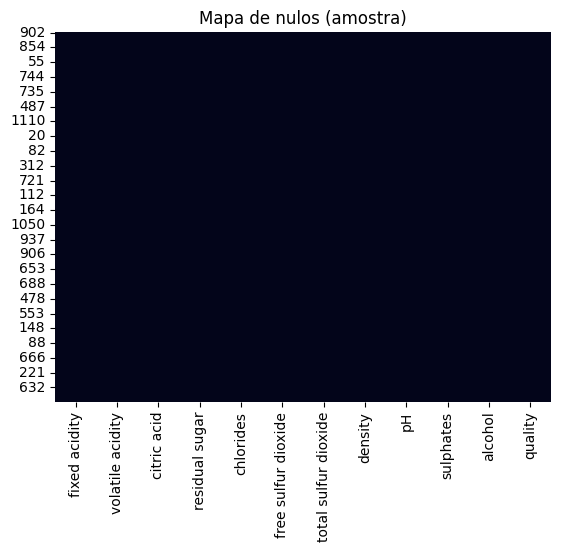

,Duplicatas%
0,10.936133


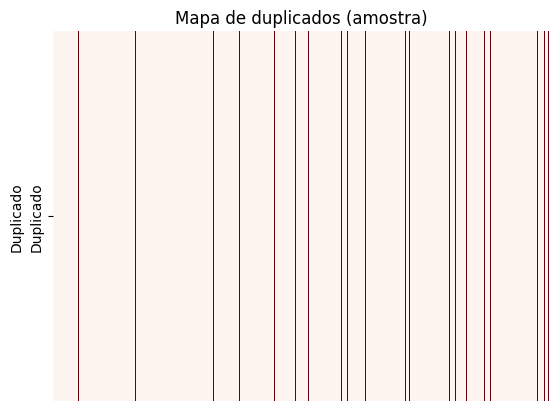

Duplicatas: 125
pH: valores fora de [0, 14] = 0
alcohol: valores fora de [0, inf] = 0
density: valores fora de [0.9, 1.5] = 0


In [11]:
# Nulos
na = df.isna().mean().sort_values(ascending=False)
display((na*100).round(2).to_frame('missing_%'))
sns.heatmap(df.sample(min(500, len(df))).isna(), cbar=False)
plt.title('Mapa de nulos (amostra)'); plt.show()

# Duplicatas
num_dups = df.duplicated().sum()
display(pd.DataFrame({'Duplicatas%': [100 * num_dups / len(df)]}))
# para visualizar duplicatas como heatmap, precisamos uma matriz 2D
dups_sample = df.sample(min(500, len(df)))
dup_mask = dups_sample.duplicated().to_frame('Duplicado').astype(int)
sns.heatmap(dup_mask.T, cbar=False, cmap='Reds', xticklabels=False, yticklabels=True)
plt.title('Mapa de duplicados (amostra)'); plt.ylabel('Duplicado'); plt.show()
print('Duplicatas:', num_dups)

# Regras simples de domínio
checks = {
    'pH': (0, 14),
    'alcohol': (0, np.inf),
    'density': (0.9, 1.5)
}
for col, (lo, hi) in checks.items():
    if col in df.columns:
        out = df[(df[col] < lo) | (df[col] > hi)]
        print(f'{col}: valores fora de [{lo}, {hi}] =', len(out))

- Vemos que temos valores duplicados. Vamos remove-los
- Tambem deixar para remover nulos, mesmo estando zero

In [12]:
missing = df.isna().sum().sort_values(ascending=False)
print(missing[missing>0])

num_dupes = df.duplicated().sum()
print(f"Duplicatas: {num_dupes}")


Series([], dtype: int64)
Duplicatas: 125


- A decisão de dropar as linhas foi tomada pelo tamanho da amostra duplicada: 125 de 1143 ≈ 10,9%, número não representativo para manter.

In [13]:
# drop duplicados
df = df.drop_duplicates()


In [14]:
num_dupes = df.duplicated().sum()
print(f"Duplicatas: {num_dupes}")

Duplicatas: 0


- Validando se realmente valores duplicados foram removidos
- Agora vamos para a segunda parte, configuracao

# 2. Config


In [15]:
sns.set_theme(context='notebook', style='whitegrid')
plt.rcParams['figure.figsize'] = (6, 3.5)

RANDOM_STATE = 42
target_col = 'quality_class'
order = ['Baixa (3-4)', 'Média (5-6)', 'Alta (7-8)']
palette_classes = {'Baixa (3-4)': '#d62728', 'Média (5-6)': '#1f77b4', 'Alta (7-8)': '#2ca02c'}

num_cols_all = df.select_dtypes(include=[np.number]).columns.tolist()
num_cols_no_target = [c for c in num_cols_all if c != 'quality']

if 'quality_class' not in df.columns:
    df['quality_class'] = df['quality'].apply(lambda x: 'Baixa (3-4)' if x <= 4 else 'Média (5-6)' if x <= 6 else 'Alta (7-8)')

ordinal_map = {'Baixa (3-4)': 0, 'Média (5-6)': 1, 'Alta (7-8)': 2}
y_ord = df['quality_class'].map(ordinal_map)

display(df.head(3))
print('shape:', df.shape)
df.info(memory_usage='deep')

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,quality_class
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,Média (5-6)
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,Média (5-6)
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,Média (5-6)


shape: (1018, 13)
<class 'pandas.core.frame.DataFrame'>
Index: 1018 entries, 0 to 1142
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1018 non-null   float64
 1   volatile acidity      1018 non-null   float64
 2   citric acid           1018 non-null   float64
 3   residual sugar        1018 non-null   float64
 4   chlorides             1018 non-null   float64
 5   free sulfur dioxide   1018 non-null   float64
 6   total sulfur dioxide  1018 non-null   float64
 7   density               1018 non-null   float64
 8   pH                    1018 non-null   float64
 9   sulphates             1018 non-null   float64
 10  alcohol               1018 non-null   float64
 11  quality               1018 non-null   int64  
 12  quality_class         1018 non-null   object 
dtypes: float64(11), int64(1), object(1)
memory usage: 190.6 KB


## 3. Distribuições univariadas


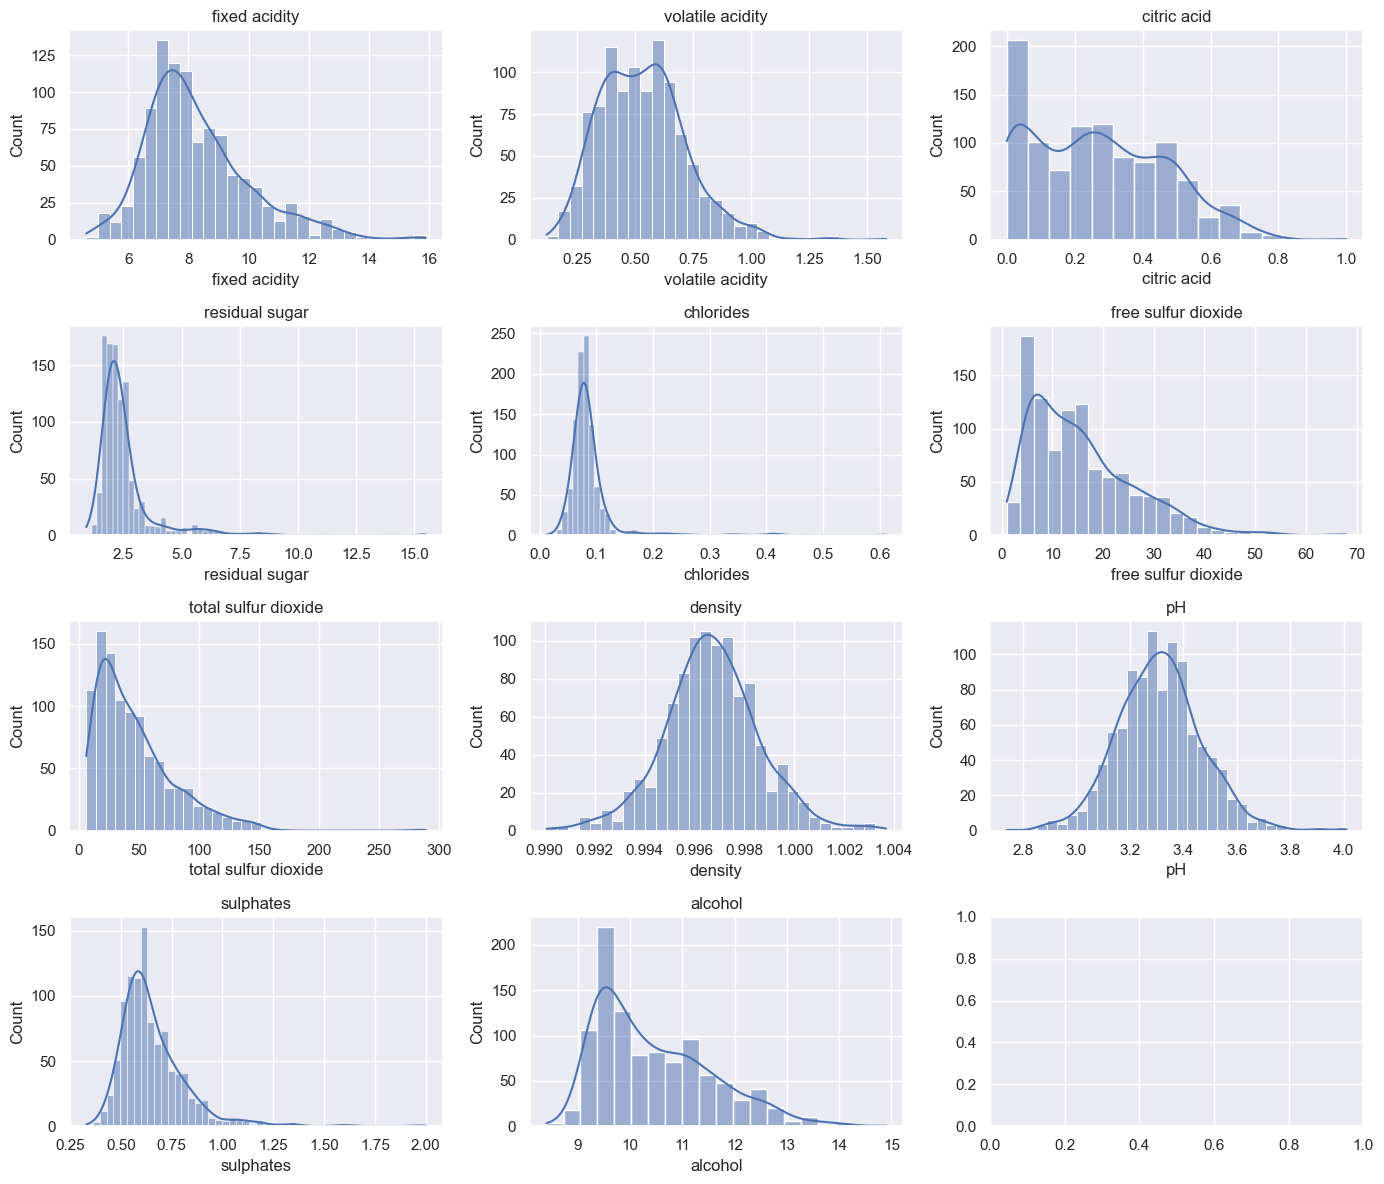

In [16]:
sns.set_theme()
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(14, 12))
axes = axes.flatten()
for i, col in enumerate(num_cols_no_target):
    sns.histplot(df[col], kde=True, ax=axes[i])
    axes[i].set_title(col)
plt.tight_layout()
plt.show()


- Contexto do alvo - Análise da distribuição de qualidade


Distribuição da variável 'quality':
quality
3      6
4     33
5    433
6    409
7    122
8     15
Name: count, dtype: int64

Estatísticas da qualidade:
Média: 5.64
Mediana: 6.00
Desvio padrão: 0.81
Min: 3, Max: 8


Text(0, 0.5, 'Frequency')

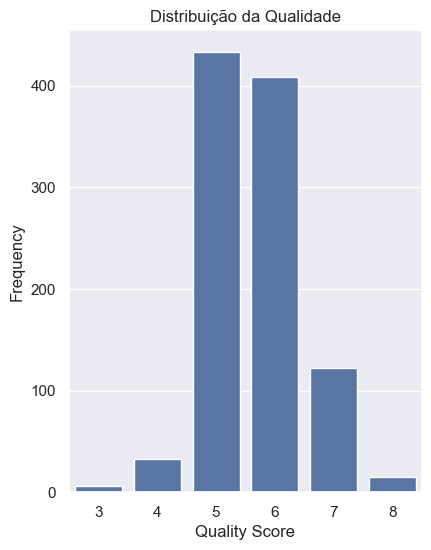

In [17]:
print("Distribuição da variável 'quality':")
print(df['quality'].value_counts().sort_index())
print("\nEstatísticas da qualidade:")
print(f"Média: {df['quality'].mean():.2f}")
print(f"Mediana: {df['quality'].median():.2f}")
print(f"Desvio padrão: {df['quality'].std():.2f}")
print(f"Min: {df['quality'].min()}, Max: {df['quality'].max()}")

# Visualização da distribuição
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
sns.countplot(data=df, x='quality')
plt.title('Distribuição da Qualidade')
plt.xlabel('Quality Score')
plt.ylabel('Frequency')


- distribuição por classes propostas



3. DISTRIBUIÇÃO POR CLASSES PROPOSTAS:
quality_class
Média (5-6)    842
Alta (7-8)     137
Baixa (3-4)     39
Name: count, dtype: int64

Percentuais:
   Média (5-6): 82.7%
   Alta (7-8): 13.5%
   Baixa (3-4): 3.8%


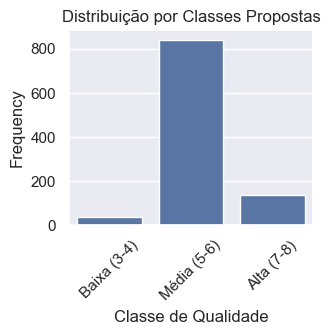

In [18]:
df_temp = df.copy()
df_temp['quality_class'] = df_temp['quality'].apply(
    lambda x: 'Baixa (3-4)' if x <= 4 else 'Média (5-6)' if x <= 6 else 'Alta (7-8)'
)

print("\n3. DISTRIBUIÇÃO POR CLASSES PROPOSTAS:")
class_counts = df_temp['quality_class'].value_counts()
print(class_counts)
print("\nPercentuais:")
for cls, count in class_counts.items():
    print(f"   {cls}: {count/len(df_temp)*100:.1f}%")

plt.subplot(1, 2, 2)
sns.countplot(data=df_temp, x='quality_class', order=['Baixa (3-4)', 'Média (5-6)', 'Alta (7-8)'])
plt.title('Distribuição por Classes Propostas')
plt.xlabel('Classe de Qualidade')
plt.ylabel('Frequency')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## 4. Alvo e desbalanceamento


,count,pct (%)
quality_class,,
Baixa (3-4),39,3.8
Média (5-6),842,82.7
Alta (7-8),137,13.5


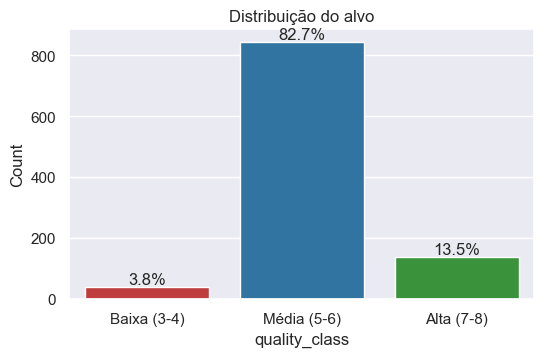

Baseline (classe majoritária) accuracy: 0.827


In [19]:
counts = df[target_col].value_counts().reindex(order)
pcts = counts.div(counts.sum()).mul(100).round(1)
display(pd.DataFrame({'count': counts, 'pct (%)': pcts}))
ax = sns.barplot(x=counts.index, y=counts.values, order=order, palette=[palette_classes[c] for c in order])
for i, v in enumerate(counts.values):
    ax.text(i, v, f"{pcts.iloc[i]}%", ha='center', va='bottom')
plt.ylabel('Count')
plt.xlabel(target_col)
plt.title('Distribuição do alvo')
plt.show()

baseline_acc = (counts.max()/counts.sum()).round(3)
print('Baseline (classe majoritária) accuracy:', baseline_acc)


## 5. Distribuições univariadas com box


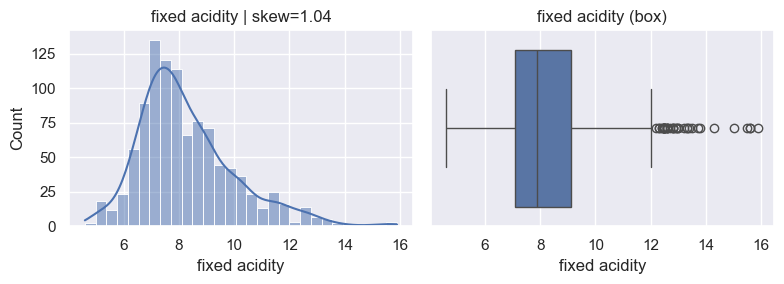

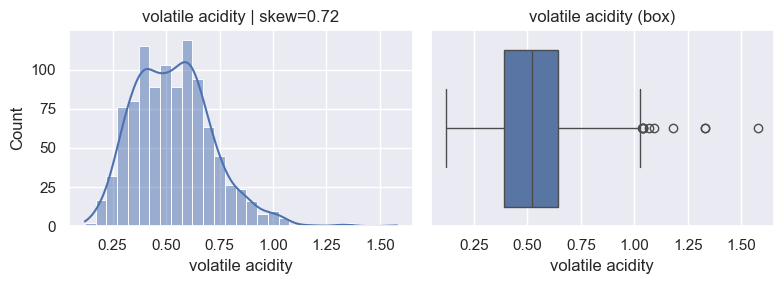

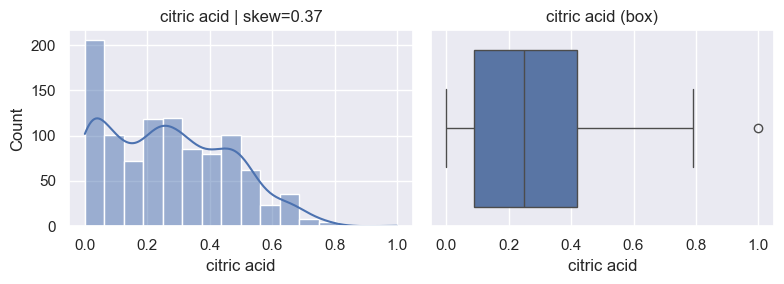

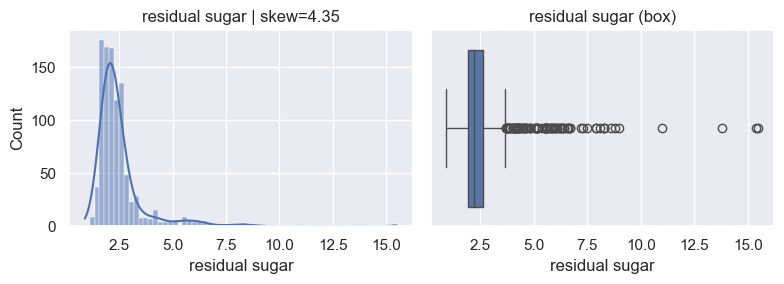

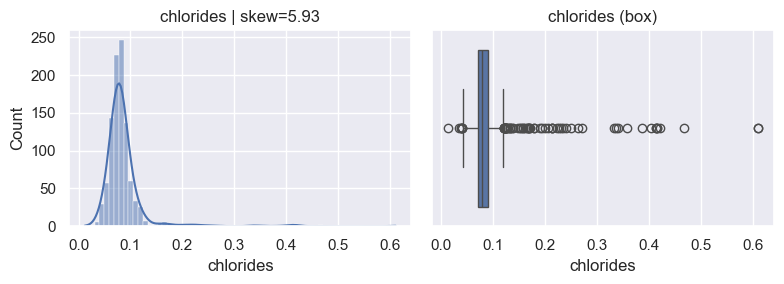

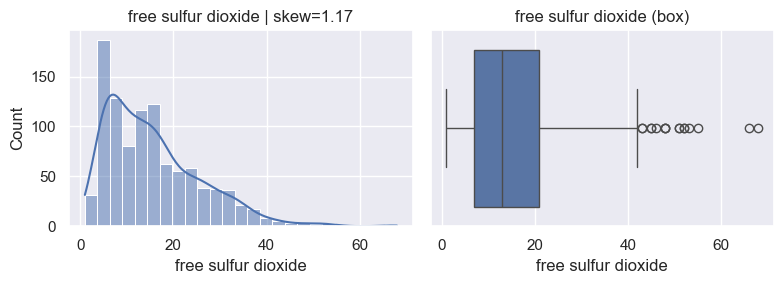

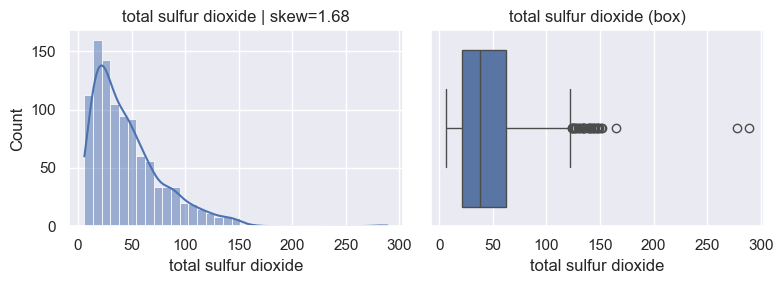

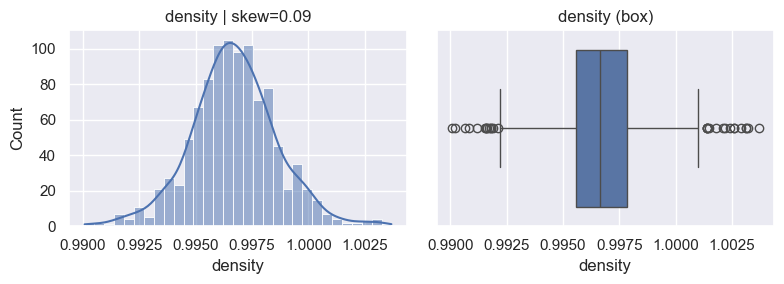

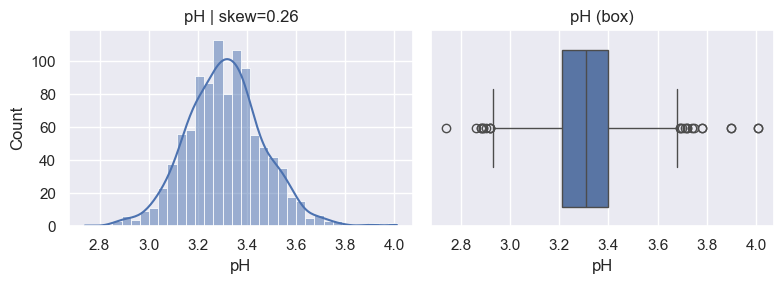

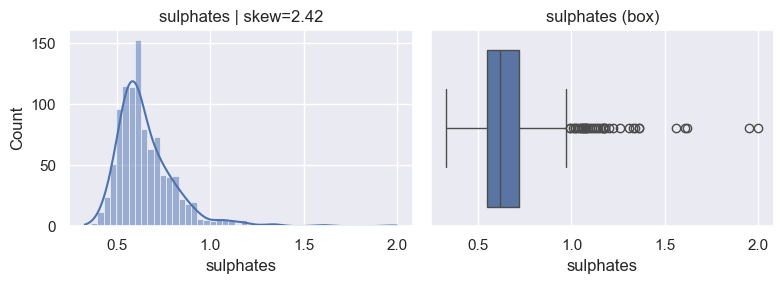

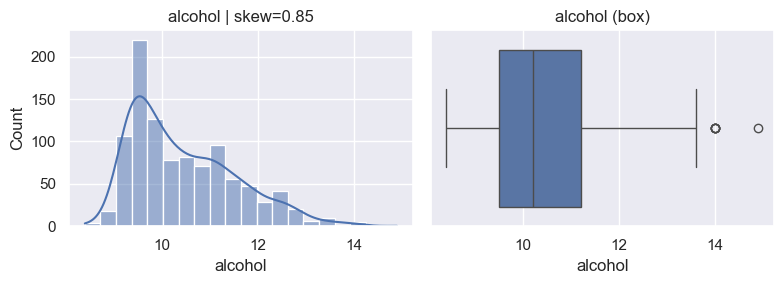

In [20]:
for col in num_cols_no_target:
    fig, ax = plt.subplots(1, 2, figsize=(8, 3))
    sns.histplot(df[col].dropna(), kde=True, ax=ax[0])
    ax[0].set_title(f'{col} | skew={df[col].dropna().skew():.2f}')
    sns.boxplot(x=df[col].dropna(), ax=ax[1])
    ax[1].set_title(f'{col} (box)')
    plt.tight_layout(); plt.show()

## 6. Comparação por classe (violin) e Kruskal


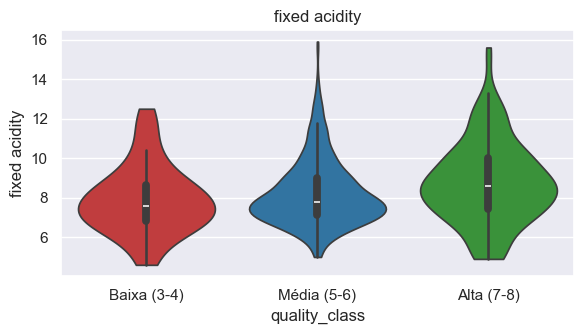

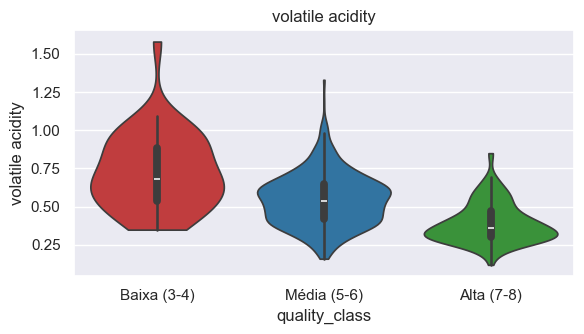

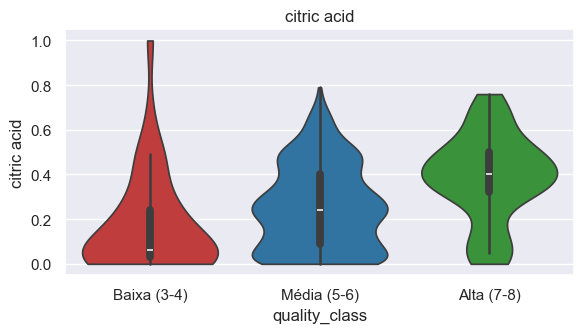

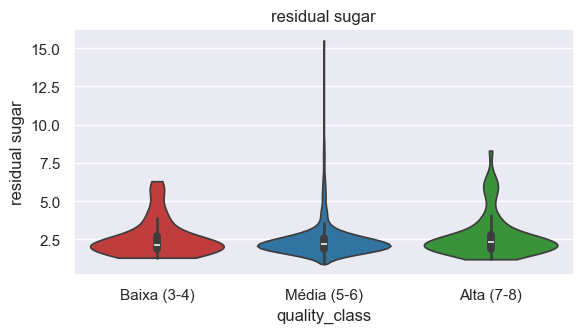

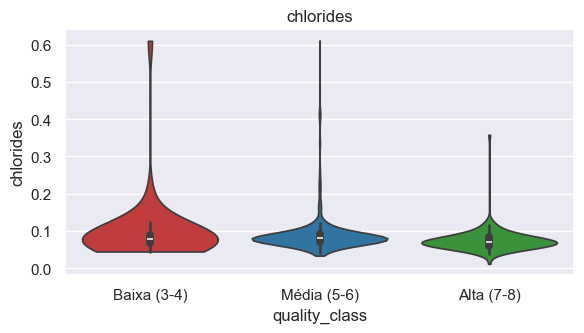

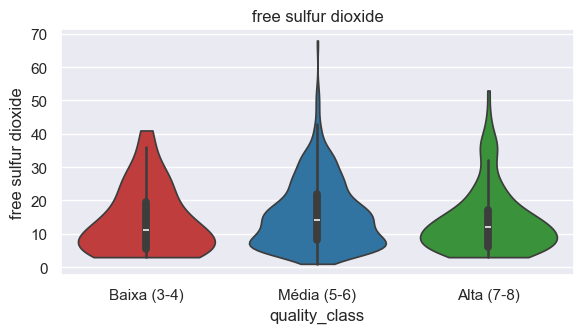

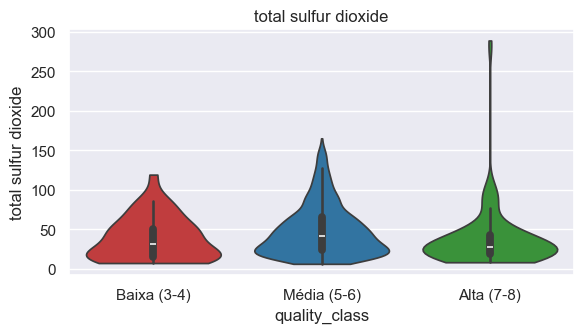

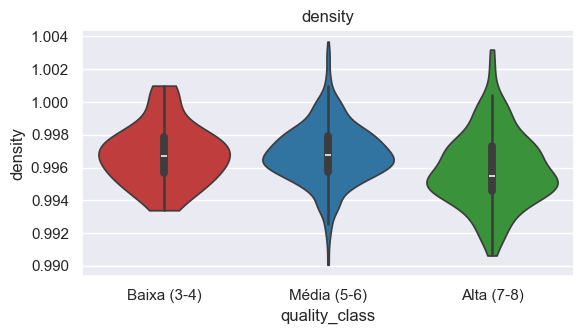

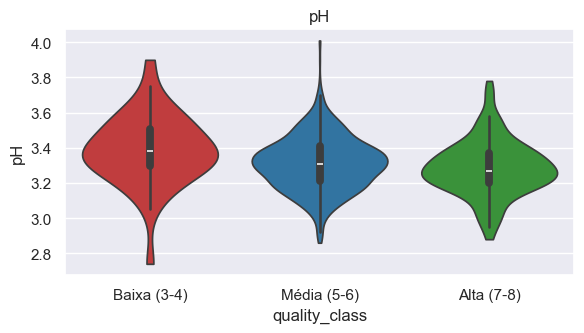

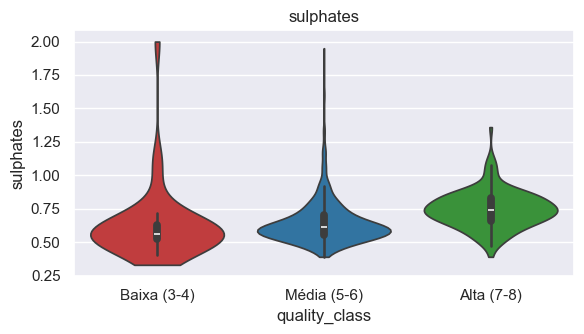

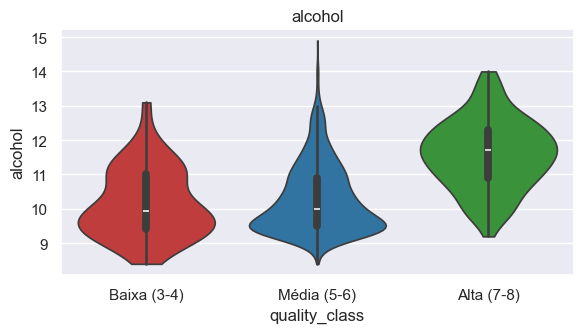

,feature,H,p_value,epsilon_sq
10,alcohol,152.205262,8.892978e-34,0.147985
1,volatile acidity,128.372431,1.331315e-28,0.124505
9,sulphates,93.148249,5.930821e-21,0.089801
2,citric acid,64.770323,8.615947e-15,0.061843
4,chlorides,38.949904,3.484462e-09,0.036404
7,density,30.249029,2.700890e-07,0.027832
6,total sulfur dioxide,29.174624,4.621798e-07,0.026773
0,fixed acidity,14.056589,8.864423e-04,0.011878
8,pH,13.052292,1.464640e-03,0.010889
5,free sulfur dioxide,8.631994,1.335323e-02,0.006534


In [21]:
cat_order = order if set(order) == set(df[target_col].unique()) else None
key_cols = num_cols_no_target

for col in key_cols:
    sns.violinplot(data=df, x=target_col, y=col, order=cat_order, cut=0, inner='box', palette=[palette_classes[c] for c in order])
    plt.title(col); plt.tight_layout(); plt.show()

def kruskal_with_effect(x, y_cat, levels):
    groups = [x[y_cat==lv].dropna() for lv in levels]
    H, p = stats.kruskal(*groups)
    n = sum(len(g) for g in groups); k = len(groups)
    eps_sq = (H - k + 1) / (n - k) if (n - k) > 0 else np.nan
    return H, p, eps_sq

res = []
for col in key_cols:
    H, p, e2 = kruskal_with_effect(df[col], df[target_col], order)
    res.append((col, H, p, e2))
kruskal_df = pd.DataFrame(res, columns=['feature','H','p_value','epsilon_sq']).sort_values('p_value')
display(kruskal_df.head(12))

## 7. Correlações e VIF (Variance Inflation Factor) - detectar multicollinearity


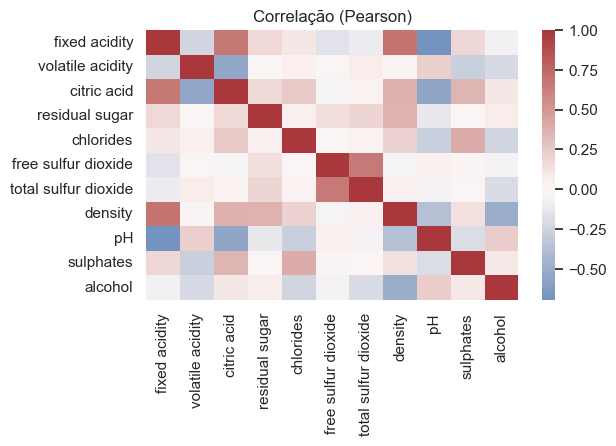

,spearman_vs_target
alcohol,0.356021
sulphates,0.296902
citric acid,0.251804
fixed acidity,0.116301
residual sugar,0.042386
free sulfur dioxide,-0.045000
pH,-0.102750
total sulfur dioxide,-0.109328
density,-0.152001
chlorides,-0.161253


,VIF
fixed acidity,7.965791
density,6.623689
pH,3.482671
alcohol,3.293191
citric acid,3.239711
total sulfur dioxide,2.115083
free sulfur dioxide,1.889682
volatile acidity,1.774989
residual sugar,1.712534
chlorides,1.575406


In [22]:
corr = df[num_cols_no_target].corr(method='pearson')
sns.heatmap(corr, cmap='vlag', center=0)
plt.title('Correlação (Pearson)'); plt.show()

# Spearman com alvo ordinal
spearman_vs_target = df[num_cols_no_target].apply(lambda s: s.corr(y_ord, method='spearman'))
display(spearman_vs_target.sort_values(ascending=False).to_frame('spearman_vs_target'))

# VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor
X_vif = df[num_cols_no_target].dropna()
X_vif_std = pd.DataFrame(StandardScaler().fit_transform(X_vif), columns=X_vif.columns)
vif = pd.Series([variance_inflation_factor(X_vif_std.values, i) for i in range(X_vif_std.shape[1])],
                index=X_vif_std.columns, name='VIF').sort_values(ascending=False)
display(vif.to_frame())

## 8. Interações e separabilidade


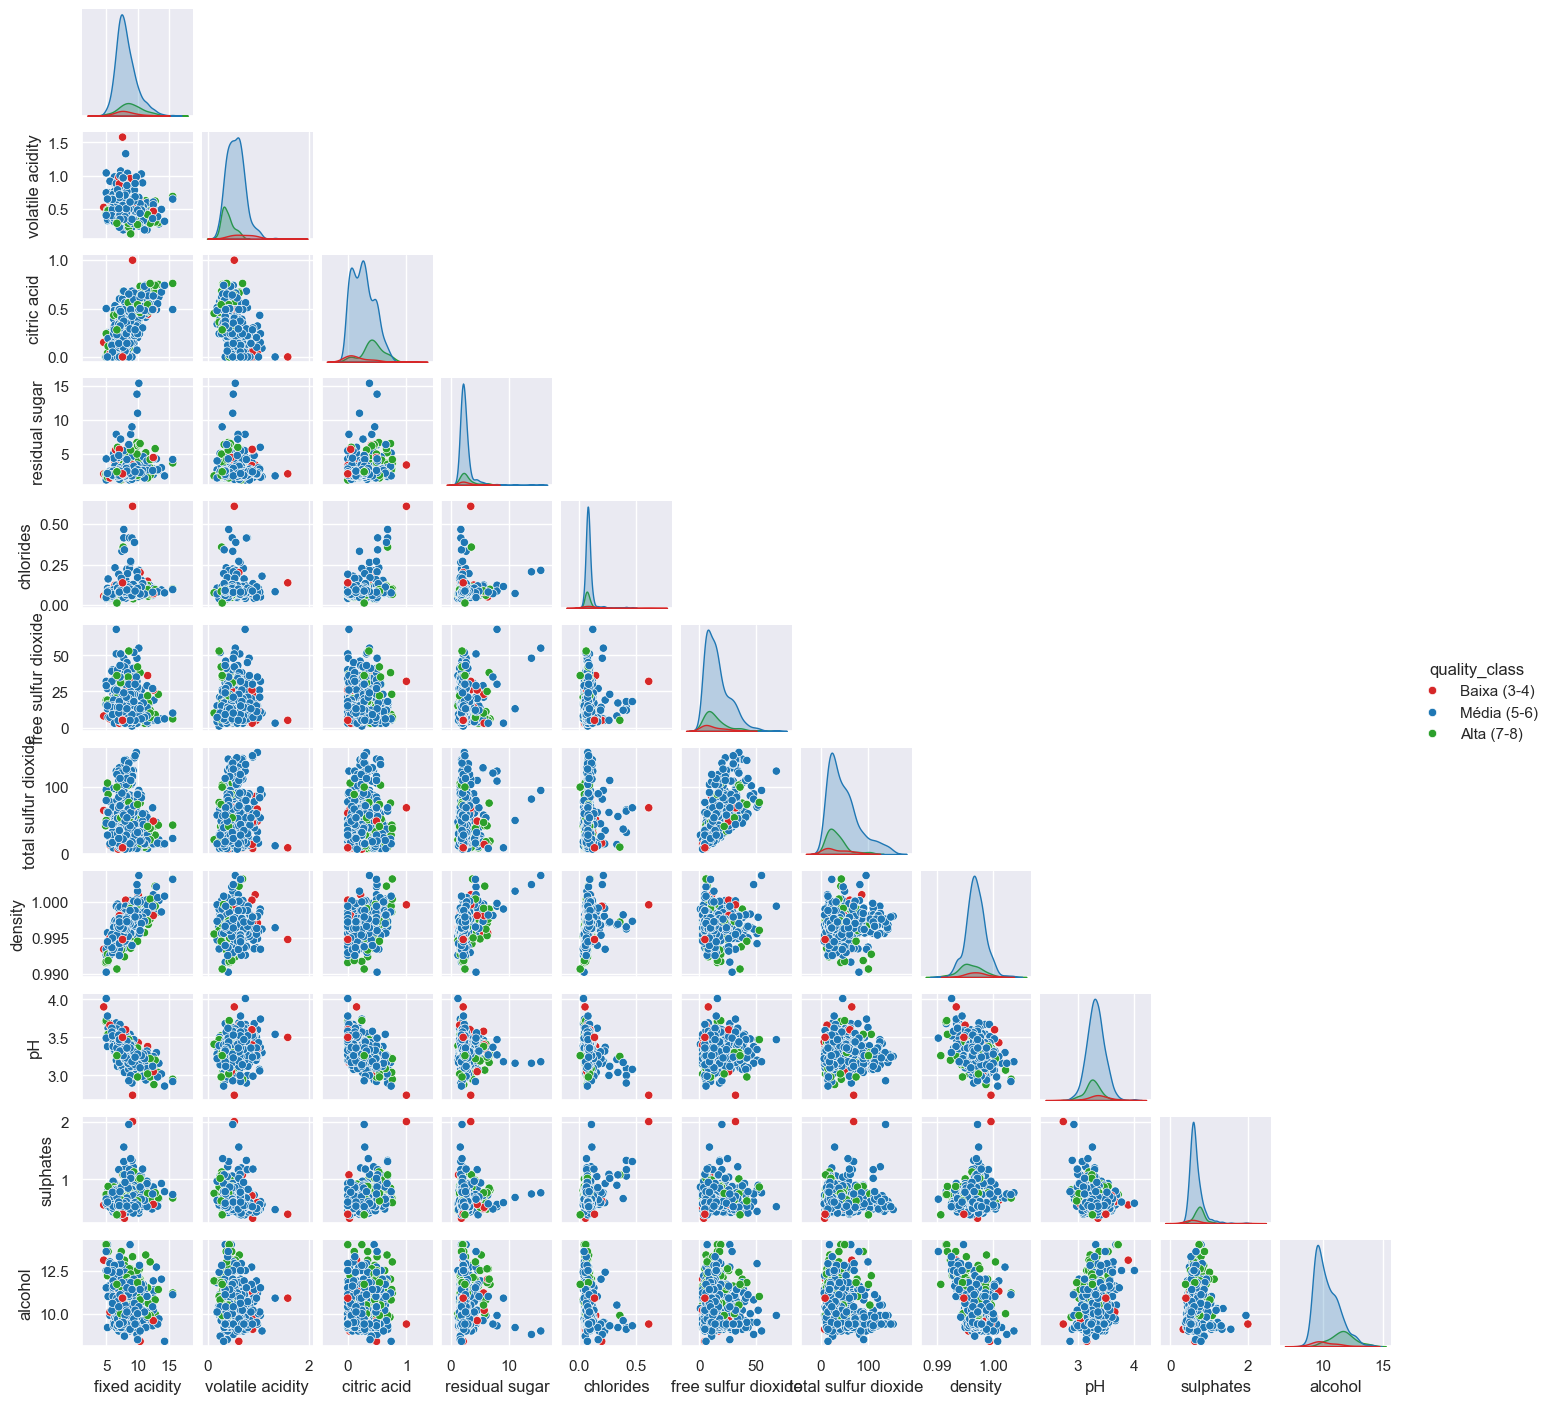

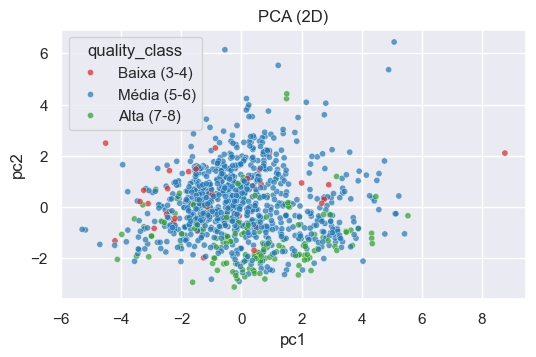

In [23]:
sample_idx = df.sample(min(600, len(df)), random_state=RANDOM_STATE).index
sns.pairplot(df.loc[sample_idx, num_cols_no_target + [target_col]], hue=target_col, hue_order=order, corner=True, height=1.3, palette=palette_classes)
plt.show()

X = df[num_cols_no_target].dropna()
scaler = StandardScaler()
Z = PCA(n_components=2, random_state=RANDOM_STATE).fit_transform(scaler.fit_transform(X))
tmp = pd.DataFrame({'pc1': Z[:,0], 'pc2': Z[:,1], target_col: df.loc[X.index, target_col]})
sns.scatterplot(data=tmp, x='pc1', y='pc2', hue=target_col, hue_order=order, palette=palette_classes, s=20, alpha=0.7)
plt.title('PCA (2D)'); plt.show()

## 9. Desbalanceamento e baseline simples


In [24]:
classes = df[target_col].dropna().unique()
weights = compute_class_weight('balanced', classes=classes, y=df[target_col].dropna())
class_weights = dict(zip(classes, weights))
class_weights

# Split estratificado (para avaliações rápidas)
X_all = df[num_cols_no_target]
y_all = df[target_col]
X_tr, X_te, y_tr, y_te = train_test_split(X_all, y_all, test_size=0.2, stratify=y_all, random_state=RANDOM_STATE)

# Baseline honesto com métricas robustas
clf = DummyClassifier(strategy='most_frequent', random_state=RANDOM_STATE)
clf.fit(X_tr, y_tr)
pred = clf.predict(X_te)
print('Balanced Acc:', round(balanced_accuracy_score(y_te, pred), 3))
print('Macro F1:', round(f1_score(y_te, pred, average='macro'), 3))

Balanced Acc: 0.333
Macro F1: 0.302


## 10. Outliers por classe (IQR)


In [25]:
# Diagnóstico global e por classe
outlier_summary = []
for col in num_cols_no_target:
    # Global
    Q1_g, Q3_g = df[col].quantile(0.25), df[col].quantile(0.75)
    IQR_g = Q3_g - Q1_g
    lo_g, hi_g = Q1_g - 1.5*IQR_g, Q3_g + 1.5*IQR_g
    for cls in order:
        mask_cls = df[target_col] == cls
        frac_g = (df.loc[mask_cls, col] < lo_g).mean() + (df.loc[mask_cls, col] > hi_g).mean()
        # Por classe (limiares específicos)
        Q1_c, Q3_c = df.loc[mask_cls, col].quantile(0.25), df.loc[mask_cls, col].quantile(0.75)
        IQR_c = Q3_c - Q1_c
        lo_c, hi_c = Q1_c - 1.5*IQR_c, Q3_c + 1.5*IQR_c
        frac_c = (df.loc[mask_cls, col] < lo_c).mean() + (df.loc[mask_cls, col] > hi_c).mean()
        outlier_summary.append({'feature': col, 'class': cls, 'outlier_frac_global': round(frac_g, 3), 'outlier_frac_class': round(frac_c, 3)})

outlier_df = pd.DataFrame(outlier_summary)
outlier_pivot_g = outlier_df.pivot(index='feature', columns='class', values='outlier_frac_global')
outlier_pivot_c = outlier_df.pivot(index='feature', columns='class', values='outlier_frac_class')
print('Outliers (fração) com limites globais:')
display(outlier_pivot_g.fillna(0).sort_index())
print('Outliers (fração) com limites por classe:')
display(outlier_pivot_c.fillna(0).sort_index())


Outliers (fração) com limites globais:


class,Alta (7-8),Baixa (3-4),Média (5-6)
feature,,,
alcohol,0.015,0.000,0.005
chlorides,0.044,0.128,0.071
citric acid,0.000,0.026,0.000
density,0.066,0.000,0.025
fixed acidity,0.058,0.026,0.033
free sulfur dioxide,0.015,0.000,0.017
pH,0.036,0.077,0.019
residual sugar,0.153,0.154,0.081
sulphates,0.058,0.077,0.036


Outliers (fração) com limites por classe:


class,Alta (7-8),Baixa (3-4),Média (5-6)
feature,,,
alcohol,0.000,0.000,0.010
chlorides,0.036,0.103,0.071
citric acid,0.080,0.051,0.000
density,0.022,0.000,0.030
fixed acidity,0.015,0.077,0.042
free sulfur dioxide,0.073,0.026,0.014
pH,0.044,0.051,0.013
residual sugar,0.124,0.128,0.081
sulphates,0.029,0.128,0.052


## 11. Monotonicidade vs alvo (Spearman e Kendall)


,spearman,kendall
alcohol,0.356021,0.291788
sulphates,0.296902,0.243511
citric acid,0.251804,0.206721
fixed acidity,0.116301,0.094854
residual sugar,0.042386,0.034958
free sulfur dioxide,-0.045000,-0.037230
pH,-0.102750,-0.083632
total sulfur dioxide,-0.109328,-0.089077
density,-0.152001,-0.122690
chlorides,-0.161253,-0.131307


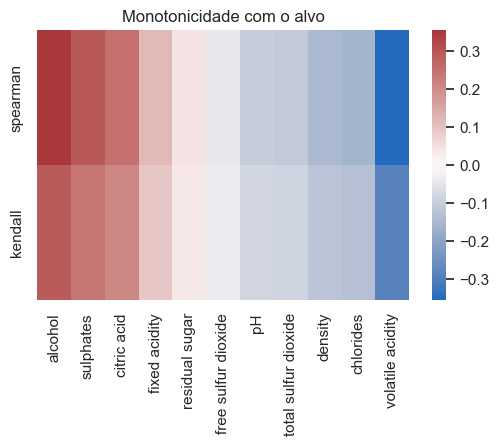

In [26]:
spearman = df[num_cols_no_target].apply(lambda s: s.corr(y_ord, method='spearman'))
kendall = df[num_cols_no_target].apply(lambda s: s.corr(y_ord, method='kendall'))
mono_df = pd.concat([spearman.rename('spearman'), kendall.rename('kendall')], axis=1).sort_values('spearman', ascending=False)
display(mono_df)

sns.heatmap(mono_df.T, cmap='vlag', center=0)
plt.title('Monotonicidade com o alvo'); plt.show()


pearman (ρ): correlação de postos (rank). Captura relações monotônicas (lineares ou não), é robusto a outliers moderados. Vai de -1 a +1. Bom quando a relação não é linear ou há escalas diferentes.

Kendall (τ): baseada em pares concordantes/discordantes. Mais conservador e robusto a outliers/empates, interpreta-se como “probabilidade de concordância” entre ranks. Também de -1 a +1. Preferido com muitos empates ou amostras menores.

In [27]:
# Baseline CV estratificado (Dummy)
# Mede baseline robusto sob desbalanceamento
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.dummy import DummyClassifier
from sklearn.metrics import make_scorer, f1_score, balanced_accuracy_score

X = df[num_cols_no_target]
y = df[target_col]

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
scoring = {
    'balanced_acc': make_scorer(balanced_accuracy_score),
    'macro_f1': make_scorer(f1_score, average='macro')
}

dummy = DummyClassifier(strategy='most_frequent', random_state=RANDOM_STATE)
cv_res = cross_validate(dummy, X, y, cv=cv, scoring=scoring, n_jobs=-1, return_train_score=False)
print('Balanced Acc CV:', np.mean(cv_res['test_balanced_acc']).round(3))
print('Macro F1 CV:', np.mean(cv_res['test_macro_f1']).round(3))


Balanced Acc CV: 0.333
Macro F1 CV: 0.302


## 12. Transformações (log1p) para alto skew & export de artefatos EDA e datasets processados


Colunas com skew alto: ['chlorides', 'residual sugar', 'sulphates', 'total sulfur dioxide', 'free sulfur dioxide', 'fixed acidity']


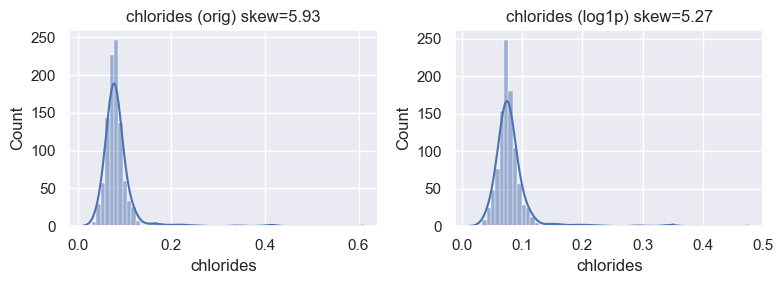

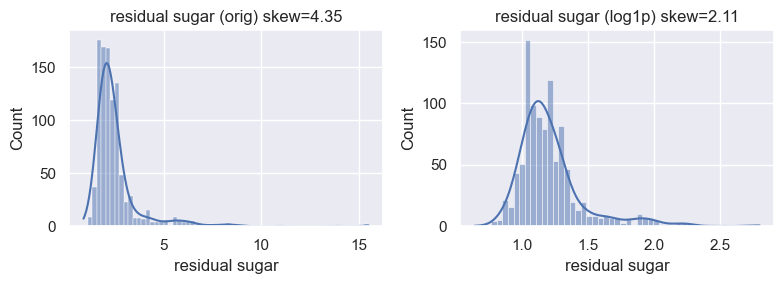

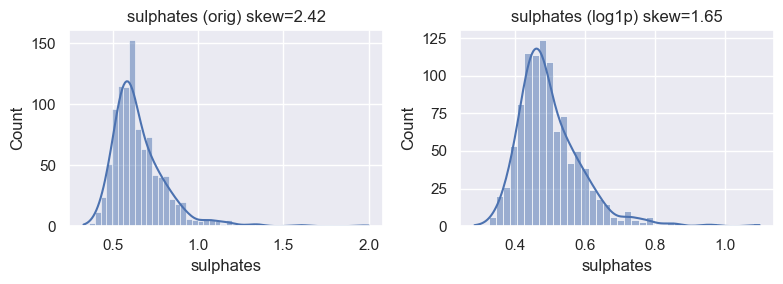

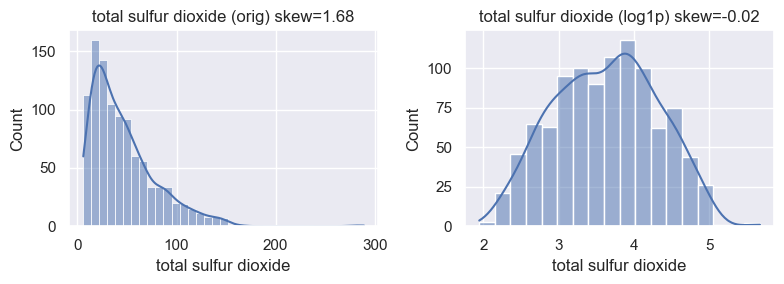

In [29]:
# 13. Transformações (log1p) para alto skew
skews = df[num_cols_no_target].apply(lambda s: s.dropna().skew()).sort_values(ascending=False)
high_skew = [c for c in skews.index if abs(skews.loc[c]) > 1]
print('Colunas com skew alto:', high_skew)

# Dados transformados
df_log = df.copy()
for col in high_skew:
    df_log[col] = np.log1p(df_log[col].clip(lower=0))

# Winsorização por classe (IQR capping) nas colunas com maior skew
cap_cols = high_skew
df_capped = df_log.copy()
for col in cap_cols:
    for cls in order:
        mask = df_capped[target_col] == cls
        Q1, Q3 = df_capped.loc[mask, col].quantile(0.25), df_capped.loc[mask, col].quantile(0.75)
        IQR = Q3 - Q1
        lo, hi = Q1 - 1.5*IQR, Q3 + 1.5*IQR
        df_capped.loc[mask, col] = df_capped.loc[mask, col].clip(lower=lo, upper=hi)

# Antes/Depois em algumas variáveis
for col in high_skew[:4]:
    fig, ax = plt.subplots(1, 2, figsize=(8, 3))
    sns.histplot(df[col].dropna(), kde=True, ax=ax[0]); ax[0].set_title(f'{col} (orig) skew={df[col].skew():.2f}')
    sns.histplot(df_log[col].dropna(), kde=True, ax=ax[1]); ax[1].set_title(f'{col} (log1p) skew={df_log[col].skew():.2f}')
    plt.tight_layout(); plt.show()


- Estamos aplicando a transformação log1p (log(1+x)) porque a variável é muito assimétrica à direita. Com ela, reduzimos o skew, comprimindo outliers e estabilizando a variância, o que tende a melhorar relações quase lineares para modelos sensíveis (ex.: regressão, kNN). Também me permite transformar valores zero sem problemas, diferente de log(x). Uso quando a feature/target é não negativa (contagens, valores monetários). sabemos que a interpretação passa a ficar no espaço log; quando precisar voltar ao original, invertemos com expm1. Caso cenario com valores negativos, deve-mos considerar o Yeo–Johnson ou um deslocamento antes de aplicar. Mas não se aplica ao caso

In [30]:
import pathlib
out_dir = pathlib.Path('reports/eda'); out_dir.mkdir(parents=True, exist_ok=True)
proc_dir = pathlib.Path('data/processed'); proc_dir.mkdir(parents=True, exist_ok=True)

# 1) Distribuição do alvo
plt.figure()
ax = sns.barplot(x=counts.index, y=counts.values, order=order, palette=[palette_classes[c] for c in order])
for i, v in enumerate(counts.values):
    ax.text(i, v, f"{pcts.iloc[i]}%", ha='center', va='bottom')
plt.tight_layout()
plt.savefig(out_dir/'target_distribution.png', dpi=150)
plt.close()
pd.DataFrame({'count': counts, 'pct (%)': pcts}).to_csv(out_dir/'target_summary.csv', index=True)

# 1.1) Selected features (ranking combinado)
try:
    # Ranking simples: média rank de -p (Kruskal) e |Spearman|
    rank_kruskal = kruskal_df.assign(rank_kruskal=lambda d: d['p_value'].rank(method='average')).set_index('feature')['rank_kruskal']
    rank_spear = mono_df['spearman'].abs().rank(ascending=False, method='average')
    rank_combo = (rank_kruskal.add(rank_spear, fill_value=0)).sort_values()
    selected_features = rank_combo.head(10).index.tolist()
except Exception:
    selected_features = num_cols_no_target
pd.Series(selected_features, name='selected_features').to_csv(out_dir/'selected_features.csv', index=False)

# 2) Outliers IQR global e por classe
try:
    outlier_pivot_g.fillna(0).to_csv(out_dir/'outliers_iqr_global.csv')
    outlier_pivot_c.fillna(0).to_csv(out_dir/'outliers_iqr_by_class.csv')
except Exception as e:
    print('Outliers export skip:', e)

# 3) Monotonicidade Spearman/Kendall
mono_df.to_csv(out_dir/'monotonicity_spearman_kendall.csv')

# 4) Correlações e VIF
plt.figure()
corr = df[num_cols_no_target].corr(method='pearson')
ax = sns.heatmap(corr, cmap='vlag', center=0)
plt.title('Correlação (Pearson)')
plt.tight_layout()
plt.savefig(out_dir/'corr_pearson.png', dpi=150)
plt.close()

from statsmodels.stats.outliers_influence import variance_inflation_factor
X_vif = df[num_cols_no_target].dropna()
X_vif_std = pd.DataFrame(StandardScaler().fit_transform(X_vif), columns=X_vif.columns)
vif = pd.Series([variance_inflation_factor(X_vif_std.values, i) for i in range(X_vif_std.shape[1])],
                index=X_vif_std.columns, name='VIF').sort_values(ascending=False)
vif.to_csv(out_dir/'vif.csv')

# 5) Kruskal
try:
    kruskal_df.to_csv(out_dir/'kruskal_effects.csv', index=False)
except Exception as e:
    print('Kruskal export skip:', e)

# 6) Persistência de datasets e splits
# df_clean (após drop dupes), df_log (log1p), df_capped (log1p + winsor por classe)
df.to_csv(proc_dir/'df_clean.csv', index=False)
df_log.to_csv(proc_dir/'df_log.csv', index=False)
df_capped.to_csv(proc_dir/'df_capped.csv', index=False)

# Splits estratificados para consumo posterior
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
folds = []
for fold, (tr, te) in enumerate(skf.split(df_capped[num_cols_no_target], df_capped[target_col])):
    folds.append({'fold': fold, 'train_idx': tr.tolist(), 'test_idx': te.tolist()})
(pd.DataFrame(folds)).to_json(proc_dir/'stratified_folds.json', orient='records', indent=2)


# 13. Conclusões e próximos passos

- Alvo desbalanceado (82,7% na classe Média). Métricas a usar: balanced accuracy e macro-F1.
- Sinais principais: alcohol (+), sulphates (+), citric acid (+); volatile acidity (−), chlorides (−), density (−), total SO2 (−).
- Skew alto tratado com log1p e winsorização por classe; separabilidade e testes reavaliados.
- Outliers diagnosticados por limites globais e por classe.
- Exportados artefatos e datasets processados (clean/log/capped) + folds estratificados.

Próximos passos:
- Modelagem baseline com class_weight='balanced' usando `selected_features`.
- Avaliar colinearidade (VIF) para decidir remoções.
- Visualizações finais por classe nas top features.
- Opcional: upload de dados processados no Hugging Face para padronizar consumo.



## 14. Reexecução (Spearman/Kendall, Kruskal, PCA) com df_capped


In [ ]:
# Upload batch com mapeamento para subpastas (raw/log/processed/folds/eda)
from huggingface_hub import CommitOperationAdd

HF_SPLIT = (os.getenv('HF_SPLIT') or 'all').lower()

def map_path_in_repo(p: str) -> str:
    name = Path(p).name
    if name == 'df_clean.csv': return 'raw/df_clean.csv'
    if name == 'df_log.csv': return 'log/df_log.csv'
    if name == 'df_capped.csv': return 'processed/full.csv'
    if name == 'df_capped_train.csv': return 'processed/train.csv'
    if name == 'df_capped_test.csv': return 'processed/test.csv'
    if name == 'stratified_folds.json': return 'folds/stratified_folds.json'
    if name == 'selected_features.csv': return 'eda/selected_features.csv'
    return f'other/{name}'

def include_by_split(path: Path) -> bool:
    name = path.name
    if HF_SPLIT == 'all': return True
    if HF_SPLIT == 'full': return name == 'df_capped.csv'
    if HF_SPLIT == 'train': return name == 'df_capped_train.csv'
    if HF_SPLIT == 'test': return name == 'df_capped_test.csv'
    return True

# Prepara operações de upload
ops = []
for path in files:
    if path.exists() and include_by_split(path):
        target = map_path_in_repo(str(path))
        ops.append(CommitOperationAdd(path_in_repo=target, path_or_fileobj=str(path)))
        print('staged:', path.name, '->', target)
    else:
        print('skip (missing or filtered):', path.name)

# Commit batch
if ops:
    api.create_commit(
        repo_id=HF_PROCESSED_REPO,
        repo_type='dataset',
        operations=ops,
        token=HF_TOKEN,
        commit_message=f"Add {len(ops)} processed files (split={HF_SPLIT})",
        create_pr=False,
    )
    print(f'✅ Commit enviado: {len(ops)} arquivos')
else:
    print('Nenhum arquivo para commit')

print('Concluído. Abra:', f'https://huggingface.co/datasets/{HF_PROCESSED_REPO}')


staged: df_clean.csv -> raw/df_clean.csv
staged: df_log.csv -> log/df_log.csv
staged: df_capped.csv -> processed/full.csv
staged: df_capped_train.csv -> processed/train.csv
staged: df_capped_test.csv -> processed/test.csv
staged: stratified_folds.json -> folds/stratified_folds.json
✅ Commit enviado: 6 arquivos
Concluído. Abra: https://huggingface.co/datasets/henriquebap/wine-ml-processed


,spearman,kendall
alcohol,0.356021,0.291788
sulphates,0.303313,0.248265
citric acid,0.251804,0.206721
fixed acidity,0.116804,0.095288
residual sugar,0.045988,0.037866
free sulfur dioxide,-0.045000,-0.037230
pH,-0.102750,-0.083632
total sulfur dioxide,-0.109447,-0.089177
density,-0.152001,-0.122690
chlorides,-0.163428,-0.133386


,feature,H,p_value,epsilon_sq
10,alcohol,152.205262,8.892978e-34,0.147985
1,volatile acidity,128.372431,1.331315e-28,0.124505
9,sulphates,96.437685,1.145046e-21,0.093042
2,citric acid,64.770323,8.615947e-15,0.061843
4,chlorides,39.246959,3.003525e-09,0.036697
7,density,30.249029,2.700890e-07,0.027832
6,total sulfur dioxide,29.219345,4.519598e-07,0.026817
0,fixed acidity,14.181182,8.329048e-04,0.012001
8,pH,13.052292,1.464640e-03,0.010889
5,free sulfur dioxide,8.631994,1.335323e-02,0.006534


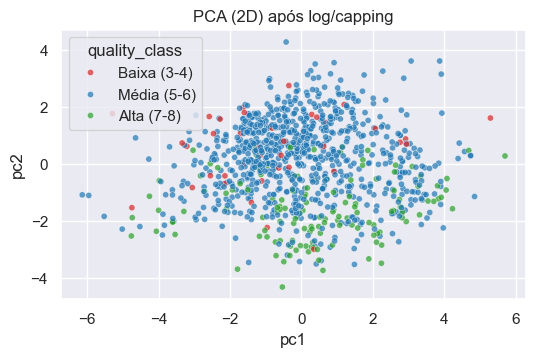

In [ ]:
# Spearman/Kendall
spearman_log = df_capped[num_cols_no_target].apply(lambda s: s.corr(y_ord, method='spearman'))
kendall_log = df_capped[num_cols_no_target].apply(lambda s: s.corr(y_ord, method='kendall'))
mono_df_log = pd.concat([spearman_log.rename('spearman'), kendall_log.rename('kendall')], axis=1).sort_values('spearman', ascending=False)
display(mono_df_log.head(10))

# Kruskal
res_log = []
for col in num_cols_no_target:
    H, p = stats.kruskal(*[df_capped.loc[df_capped[target_col]==lv, col].dropna() for lv in order])
    n = sum([df_capped.loc[df_capped[target_col]==lv, col].dropna().shape[0] for lv in order]); k = len(order)
    e2 = (H - k + 1) / (n - k) if (n - k) > 0 else np.nan
    res_log.append((col, H, p, e2))
kruskal_df_log = pd.DataFrame(res_log, columns=['feature','H','p_value','epsilon_sq']).sort_values('p_value')
display(kruskal_df_log.head(12))

# PCA
Xc = df_capped[num_cols_no_target].dropna()
Zc = PCA(n_components=2, random_state=RANDOM_STATE).fit_transform(StandardScaler().fit_transform(Xc))
tmp = pd.DataFrame({'pc1': Zc[:,0], 'pc2': Zc[:,1], target_col: df_capped.loc[Xc.index, target_col]})
sns.scatterplot(data=tmp, x='pc1', y='pc2', hue=target_col, hue_order=order, palette=palette_classes, s=20, alpha=0.7)
plt.title('PCA (2D) após log/capping'); plt.show()
